In [ ]:
from IPython.display import display, Image, HTML
from ipywidgets import Button, Output
import os

path = "Si_nano_muestra_3/"
extetion = ".png"
files = []

for r, d, f in os.walk(path):
    for file in f:
        if extetion in file:
            files.append(r+'/'+file)

# List of image file names
image_files = files

# Current image index
current_image_index = 0

# Output widget to display the image
out = Output()

# Function to update and display the current image
def display_image():
    with out:
        # Clear the output area
        out.clear_output()
        # Get the current image file name
        image_file = image_files[current_image_index]
        # Display the image
        display(Image(retina=False,filename=image_file, metadata={'Title': 'Hello'}))
        # Add the file name to the image
        file_name = os.path.basename(image_file)
        # Display the text next to the image
        text = "<b>" + file_name + "</b>"
        #display(HTML("<div style='float: center; font-size: 50px;'><center><br>" + text + "<br>" + text + "<br>" + text + "</center></div>"))

# Button click event handlers
def previous_image(btn):
    global current_image_index
    current_image_index = (current_image_index - 1) % len(image_files)
    display_image()

def next_image(btn):
    global current_image_index
    current_image_index = (current_image_index + 1) % len(image_files)
    display_image()

# Create buttons
previous_button = Button(description='Previous')
previous_button.on_click(previous_image)

next_button = Button(description='Next')
next_button.on_click(next_image)

# Display buttons and output widget
display(previous_button, next_button)
display(out)

# Display initial image
display_image()

Button(description='Previous', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

Output()

In [1]:
import os

path = "../raman_2"
extetion = ".txt"
files = []

for r, d, f in os.walk(path):
    for file in f:
        if extetion in file:
            files.append(r+'/'+file)

files

['../raman_2/Si_nano_muestra 3_33.txt',
 '../raman_2/Si_nano_muestra 3_46.txt',
 '../raman_2/Si_nano_muestra 3_34.txt',
 '../raman_2/Si_nano_muestra 3_63.txt',
 '../raman_2/Si_nano_muestra 3_64.txt',
 '../raman_2/Si_nano_muestra 3_59.txt',
 '../raman_2/Si_nano_muestra 3_31.txt',
 '../raman_2/Si_nano_muestra 3_16.txt',
 '../raman_2/Si_nano_muestra 3_01.txt',
 '../raman_2/Si_nano_muestra 3_37.txt',
 '../raman_2/Si_nano_muestra 3_57.txt',
 '../raman_2/Si_nano_muestra 3_38.txt',
 '../raman_2/Si_nano_muestra 3_32.txt',
 '../raman_2/Si_nano_muestra 3_48.txt',
 '../raman_2/Si_nano_muestra 3_65.txt',
 '../raman_2/Si_nano_muestra 3_25.txt',
 '../raman_2/Si_nano_muestra 3_17.txt',
 '../raman_2/Si_nano_muestra 3_62.txt',
 '../raman_2/Si_nano_muestra 3_60.txt',
 '../raman_2/Si_nano_muestra 3_52.txt']

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt



class RamanSpectrum:
    """
    A Class to perform ploting, cutting spectrums in a certain range
    denoise, baseline and multipeak fit. It needs the path of a 
    RamanSpectrum of type txt. It should be noted that the format of this txt 
    may be different for an observation made in another device. But in general the main
    part is inside the x,y pairs so the read of another type of format can be modified to
    provide x, and yas an np array in the initialization method.
    """

    def __init__(self, filepath, x=None,y=None):
        # Read in the data from the file or reading the x, y values

        with open(filepath, 'r', encoding='iso-8859-1') as f:
            lines = f.readlines()
        
        # Extract the metadata from the file
        self.metadata = {}
        # Creating an empty dictionary to store the coordinates
        self.dictcoords = {}

        for line in lines:
            if line.startswith("#"):
                # Storing the metadata
                key, value = line.strip().split("=")
                self.metadata[key[1:]] = value.replace('\t', '')
        
        # Now that we have the metadata stored in a dictionary, we can
        # store the value of the keys in a set of strings

        self.metakeys = self.metadata.keys()
        
        # Extract the x and y data from the file
        
        self.data = np.loadtxt(lines[len(self.metadata):])
        self.x = self.data[:,0]
        self.y = self.data[:,1]

        self.sample = self.metadata['Acquired'].replace(' ', '_')

        # Creating a folder to store the data
        if not os.path.exists(self.sample):
            os.makedirs(self.sample)
        
        # Saving the data as an dictionary
        for e in self.data:
            self.dictcoords[e[0]] = e[1]
    
    def plot(self):
        """Plotting the data"""
        plt.plot(self.x, self.y)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.show()

    def acces_value(self, pattern):
        matched_keys = set()
        regex = re.compile(pattern, re.IGNORECASE)
        for key in self.metakeys:
            if regex.search(key):
                matched_keys.add(key)
        return (matched_keys, [self.metadata[key] for key in matched_keys])
    
    def crop(self, lower, upper, show = False):
        """
        This method crops the x and y values to only a subset of the 
        original points. It also plots the cropped data if the show
        parameter is set to True. Always saves the cropped data as an
        image.
        """
        self.croppedx = []
        self.croppedy = []
        for e in self.x:
            if e > lower and e < upper:
                self.croppedx.append(e)
                self.croppedy.append(self.dictcoords[e])
        plt.plot(self.croppedx, self.croppedy)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title(self.metadata['Date'])
        # Saving the cropped data as an image

        if not os.path.exists(self.sample+'/cropped'):
            os.makedirs(self.sample+'/cropped')

        name = self.sample+"/cropped/{i}.png".format(i = self.metadata['Date'])
        plt.savefig(name)
        if show:
            plt.show()
        plt.clf()
    
    def polifit(self, a,b,ord = 3):
        """
        a is the lowest value of the x pairs and b
        is the highest value. ord is the order of the polynomial
        to be fitted
        """
        
        x = []
        y = []
        for x_i, y_i in zip(self.croppedx,self.croppedy):
            if x_i < a or x_i > b:
                x.append(x_i)
                y.append(y_i)
        # Fitting the data
        fitted = np.polyfit(x, y, ord)
        self.fitted = fitted
        # Plotting the first part
        plt.subplot(2, 1, 1)  # Create subplot 1
        plt.plot(self.croppedx, self.croppedy)
        plt.plot(self.croppedx, np.polyval(fitted, self.croppedx))
        plt.xlim(min(self.croppedx), max(self.croppedx))
        ef = abs(max(self.croppedy) - min(self.croppedy))/20
        plt.ylim(min(self.croppedy)-ef, max(self.croppedy)+ef)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title('With baseline')
        # Plotting the second part
        plt.subplot(2, 1, 2)  # Create subplot 2
        plt.plot(self.croppedx, self.croppedy - np.polyval(fitted, self.croppedx))
        self.polylx = self.croppedx
        self.polyly = self.croppedy - np.polyval(fitted, self.croppedx)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title('Without baseline')

        # Saving both plots in the same file
        if not os.path.exists(self.sample+'/polyfit'):
            os.makedirs(self.sample+'/polyfit')
        plt.savefig(self.sample+"/polyfit/{i}.png".format(i=self.metadata['Date']))
        plt.subplots_adjust(hspace=1)
        plt.show()
    
    def sav_gol(self, window, order, x_arr,y_arr, show=False):
        """
        Takes the x and y values and applies a Savitzky-Golay filter
        sets self.denoisedx and self.denoisedy to the denoised values
        """
        self.denoisedx = []
        self.denoisedy = []    
        self.savgol = savgol_filter(y_arr, window, order)
        self.denoisedx = x_arr
        self.denoisedy = self.savgol
        plt.plot(self.denoisedx, self.denoisedy)
        self.basedx = self.denoisedx
        self.basedy = self.denoisedy
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title('Denoised')

        if not os.path.exists(self.sample+'/denoised'):
            os.makedirs(self.sample+'/denoised')

        # Saving the cropped data as an image
        name = self.sample + "/denoised/{i}.png".format(i = self.metadata['Date'])
        plt.savefig(name)
        if show:
            plt.show()
        plt.clf()

    def baseline(self,degree = 1, show = False, before=False):
        # Fit polynomial baseline

        xfit = self.denoisedx[:5] + self.denoisedx[-5:]
        self.a = list(self.denoisedy[:5])
        self.b = list(self.denoisedy[-5:])
        
        print(self.a)
        print(self.b)

        yfit = self.a + self.b
        print(type(self.denoisedx),type(self.denoisedy))
        print('The lenghts',len(xfit),len(yfit))

        coefficients = np.polyfit(xfit, yfit, degree)
        baseline = np.polyval(coefficients, self.denoisedx)

        # Plot the original signal and the baseline
        # plt.plot(self.denoisedx, self.denoisedy, label='Original Signal')
        new_zero = abs(min(self.denoisedy - baseline))
        if before:
            plt.plot(self.denoisedx, (self.croppedy + new_zero)  , label='baselined')
            plt.plot(self.denoisedx, baseline, label='Baseline')
        else:
            plt.plot(self.denoisedx, (self.denoisedy + new_zero), label='baselined')
            plt.plot(self.denoisedx, baseline, label='Baseline')
        self.basedx = self.denoisedx
        self.basedy = (self.denoisedy + new_zero) - baseline
        # plt.plot(self.denoisedx, baseline, label='Baseline')
        plt.legend()
        plt.xlabel('wavenumber (cm$^{-1}$)')
        plt.ylabel('Intensity (counts)')

        if not os.path.exists(self.sample+'/baseline'):
            os.makedirs(self.sample+'/baseline')

        plt.title(self.metadata['Date'] + ' - Baseline')
        if show:
            plt.show()
        name = self.sample + "/baseline/{i}.png".format(i = self.metadata['Date'])
        plt.savefig(name)
        plt.clf()
    

    # Define the function as the sum of three Gaussian curves
    def gaussian(self, x, amplitude, center, sigma):
        return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))

    def multi_peak_fit(self, x, *params):
        num_peaks = len(params) // 3
        y_fit = np.zeros_like(x)

        for i in range(num_peaks):
            amplitude, center, sigma = params[i*3 : (i+1)*3]
            y_fit += self.gaussian(x, amplitude, center, sigma)
        return y_fit
    
    def get_fitting(self, f2 = 0.5, f3 = 0.3 , c1 = 520, c2 = 500, c3 = 480, s1 = 10, s2 = 20, s3 = 40 ,show = False):
        x = np.array(self.basedx)
        y = np.array(self.basedy)

        yspec = max(y)
        yspec2 = yspec*f2
        yspec3 = yspec*f3

        # Perform the multi-peak fitting
        # initial_guess = [yspec3, 450, 100, yspec2, 510, 10, yspec, 520, 10]
        initial_guess = [yspec3, c3, s3, yspec2, c2, s2, yspec, c1, s1]   # Initial guess for parameters: [amplitude1, center1, sigma1, amplitude2, center2, sigma2, amplitude3, center3, sigma3]
        
        if not os.path.exists(self.sample+'/fit'):
                os.makedirs(self.sample+'/fit')

        popt, pcov = curve_fit(self.multi_peak_fit, x, y, p0=initial_guess)

        # Extract the optimized parameters
        amplitudes = popt[0::3]
        centers = popt[1::3]
        sigmas = popt[2::3]

        for i in range(0,3):
            amp,cen,sig = popt[i*3:(i+1)*3]

        self.fit_props = popt

        # Print the results

        print('Amplitudes: {}'.format(amplitudes))
        print('Centers: {}'.format(centers))
        print('Sigmas: {}'.format(sigmas))

        # Generate the fitted curve
        x_fit = np.linspace(x.min(), x.max(), 1000)
        y_fit = self.multi_peak_fit(x_fit, *popt)
        # Plot the original data and the fitted curve
        plt.plot(x, y, 'bo', label='Original Data')
        plt.plot(x_fit, y_fit, 'r-', label='Fitted Curve')
        self.x_fit = x_fit
        self.y_fit = y_fit
        plt.legend()
        plt.xlabel('wavenumber (cm$^{-1}$)')
        plt.ylabel('Counts (a.u.)')
        if show:
            plt.show()
        plt.savefig(self.sample+'/fit/{}.png'.format(self.metadata['Date']))
        self.popt = popt
        plt.clf()

    # def get_fitting(self, x_,y_, f2 = 0.5, f3 = 0.3 , c1 = 520, c2 = 500, c3 = 480, s1 = 10, s2 = 20, s3 = 40 ,show = False):
    #     """
    #     A multi-peak fitting function that takes the x and y values and fits them to a multi-peak function
    #     """
    #     x = np.array(x_)
    #     y = np.array(y_ + abs(min(y_)))

    #     yspec = max(y)
    #     yspec2 = yspec*f2
    #     yspec3 = yspec*f3

    #     # Perform the multi-peak fitting
    #     # initial_guess = [yspec3, 450, 100, yspec2, 510, 10, yspec, 520, 10]
    #     initial_guess = [yspec3, c3, s3, yspec2, c2, s2, yspec, c1, s1]   # Initial guess for parameters: [amplitude1, center1, sigma1, amplitude2, center2, sigma2, amplitude3, center3, sigma3]
        
    #     if not os.path.exists(self.sample):
    #         os.makedirs(self.sample+'/fit')
        
    #     amplitudes = popt[0::3]
    #     centers = popt[1::3]
    #     sigmas = popt[2::3]

    #     # Print the results

    #     print('Amplitudes: {}'.format(amplitudes))
    #     print('Centers: {}'.format(centers))
    #     print('Sigmas: {}'.format(sigmas))

    #     # Generate the fitted curve
    #     x_fit = np.linspace(x.min(), x.max(), 1000)
    #     y_fit = self.multi_peak_fit(x_fit, *popt)
    #     # Plot the original data and the fitted curve
    #     plt.plot(x, y, 'bo', label='Original Data')
    #     plt.plot(x_fit, y_fit, 'r-', label='Fitted Curve')
    #     plt.legend()
    #     plt.xlabel('x')
    #     plt.ylabel('y')
    #     if show:
    #         plt.show()
    #     plt.savefig(self.sample+'/fit/{}.png'.format(self.metadata['Date']))
    #     plt.clf()



In [83]:
test = RamanSpectrum(files[0])

In [ ]:
x = [a for a in range(5,40)]
z = []
for b in x:
    if 5<b<10:
        z.append(b)

z

: 

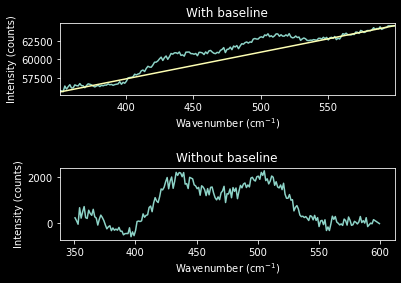

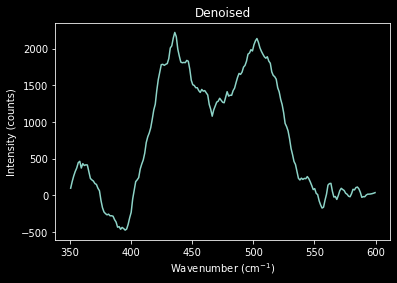

Amplitudes: [1584.79649611 1229.75259257 2026.79945261]
Centers: [430.14115443 456.62061776 504.4858381 ]
Sigmas: [12.00104602 18.09489434 17.82482653]


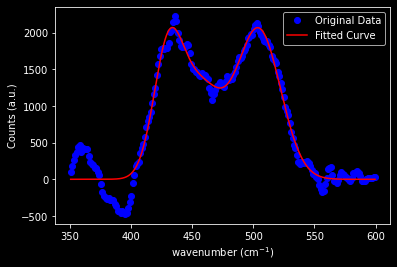

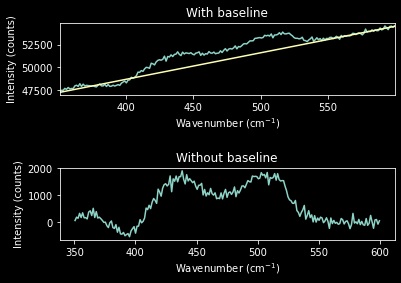

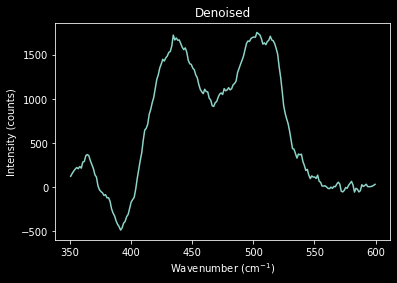

Amplitudes: [1267.20292651  991.74088006 1767.48529034]
Centers: [430.15395445 456.27910629 505.71850741]
Sigmas: [12.60466341 18.58439655 17.92576283]


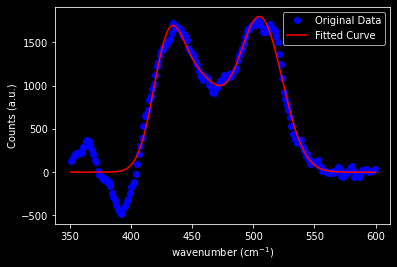

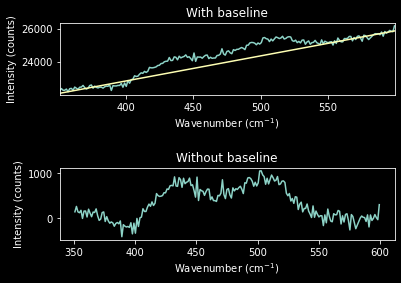

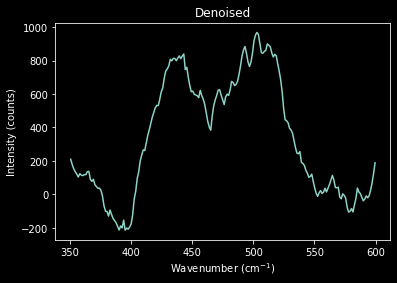

Amplitudes: [750.40658548 632.00064766 450.82038771]
Centers: [434.34408716 488.81566432 512.77204343]
Sigmas: [14.27239259 27.14397685 14.00323952]


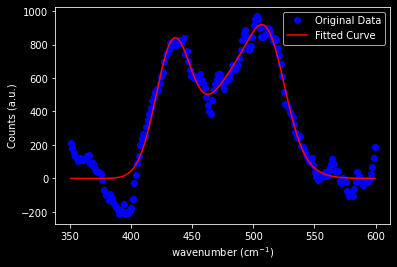

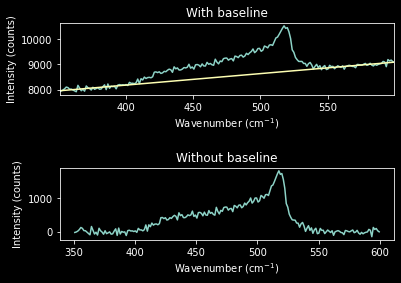

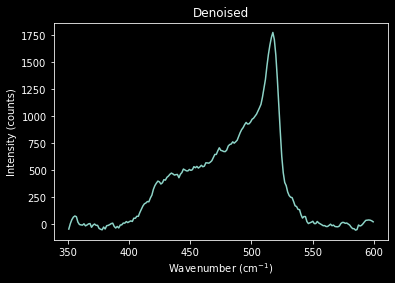

Amplitudes: [ 528.06399309  903.94019487 1117.43501883]
Centers: [449.27573538 501.62407652 517.11459835]
Sigmas: [24.74058555 18.44915212  4.7136692 ]


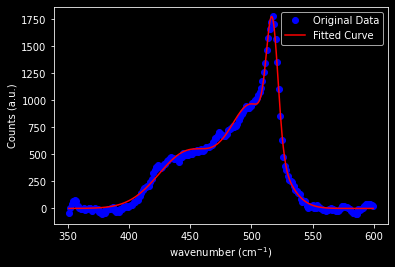

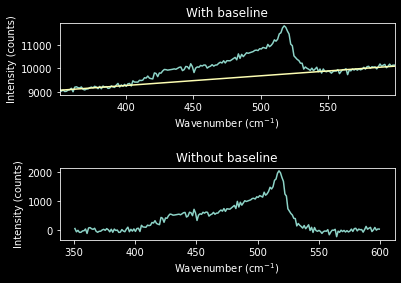

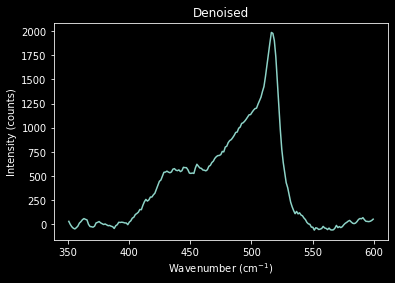

Amplitudes: [ 589.40252172 1111.61483797 1254.16374219]
Centers: [444.42140737 499.2086422  517.16287044]
Sigmas: [22.13159886 18.38617486  5.13494596]


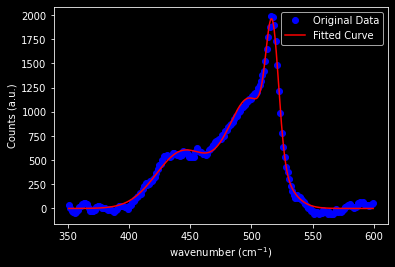

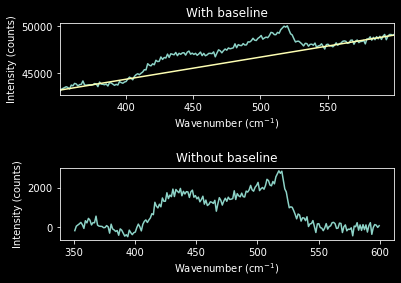

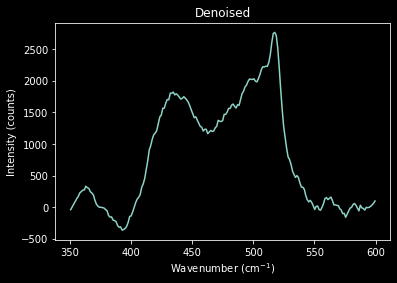

Amplitudes: [1812.9129858  1951.48965469 1420.25281058]
Centers: [436.47253405 496.01215243 517.19991349]
Sigmas: [15.78074759 22.86443047  5.37510382]


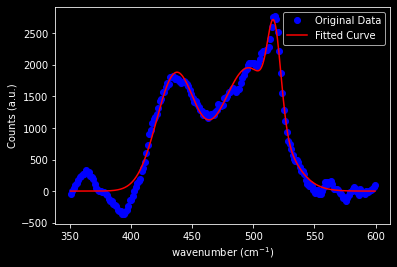

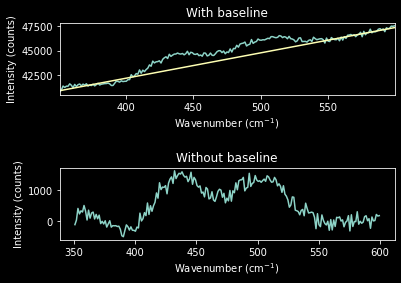

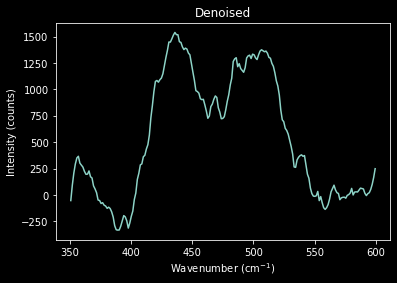

Amplitudes: [1500.60139062 1272.24306219  338.45790692]
Centers: [436.0355572  496.16935935 513.74223763]
Sigmas: [14.96763205 23.668898    6.91755289]


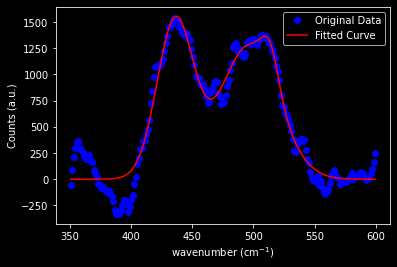

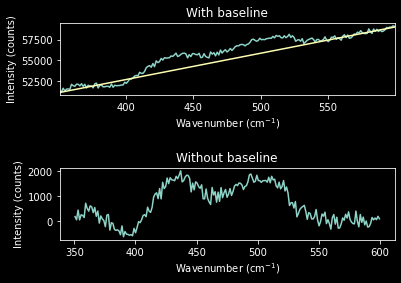

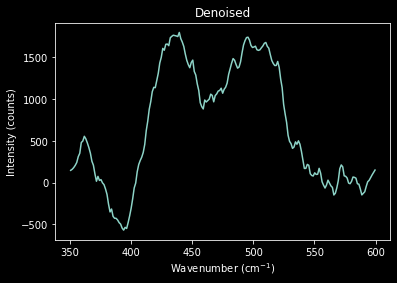

Amplitudes: [1775.00616339 1582.63957026  459.94695577]
Centers: [434.5716052  494.37042488 515.68695239]
Sigmas: [14.21971851 24.39366365  7.66259021]


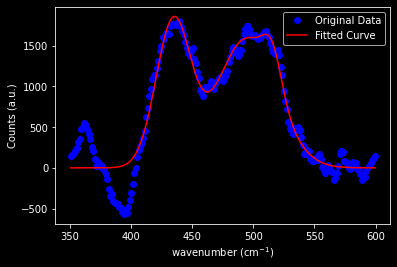

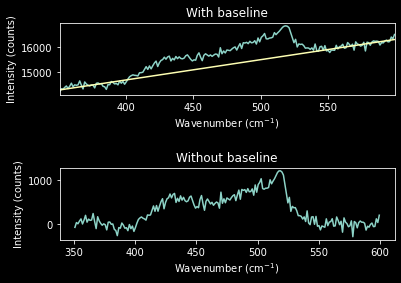

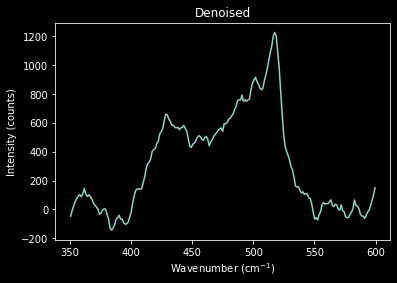

Amplitudes: [598.19644899 817.74453118 673.18391627]
Centers: [434.22687322 495.655486   517.29964233]
Sigmas: [16.39145925 23.21081357  4.96839228]


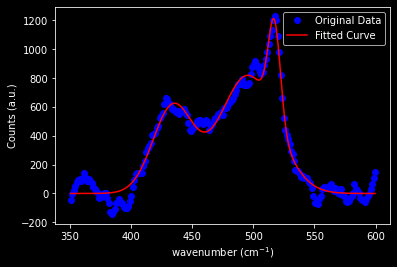

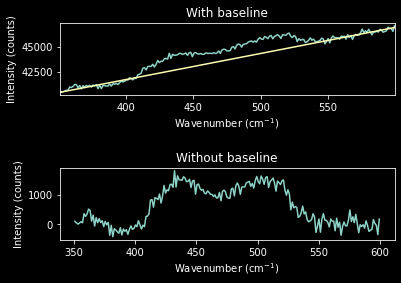

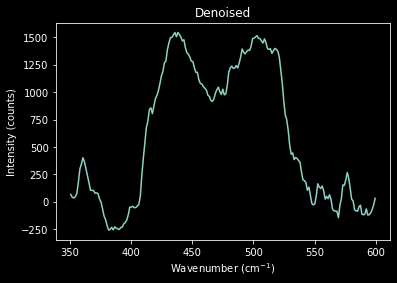

Amplitudes: [1450.88412397 1231.92548551  690.17515575]
Centers: [435.56240324 489.98468284 514.9818804 ]
Sigmas: [15.07610503 24.67864786 11.47296307]


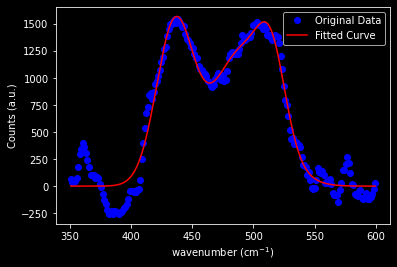

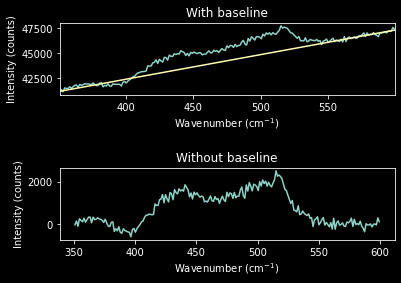

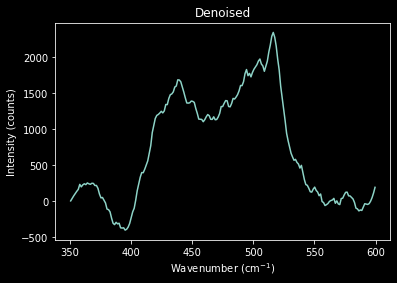

Amplitudes: [1546.93656355 1760.15375954  984.87572641]
Centers: [436.55865046 496.89254573 517.04523676]
Sigmas: [15.80671557 24.48763612  5.44746505]


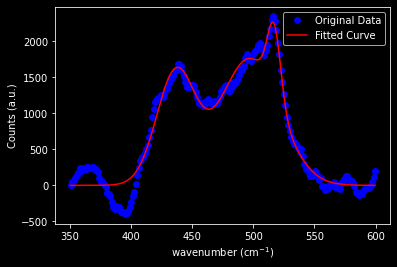

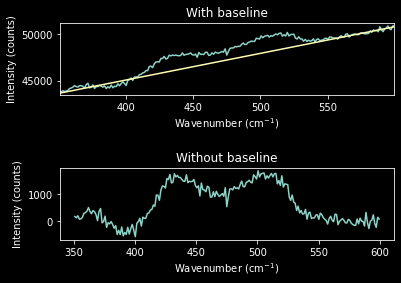

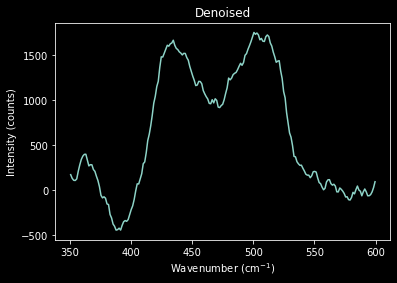

Amplitudes: [1173.99645638 1115.4847858  1774.15089394]
Centers: [428.69565879 451.55805518 504.3139762 ]
Sigmas: [10.32248409 16.75888441 19.29408575]


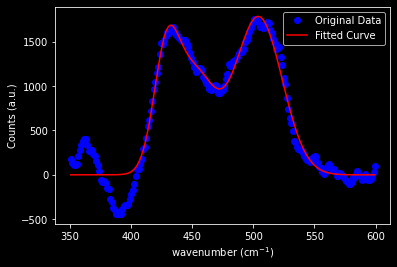

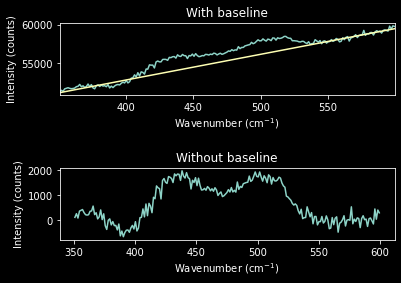

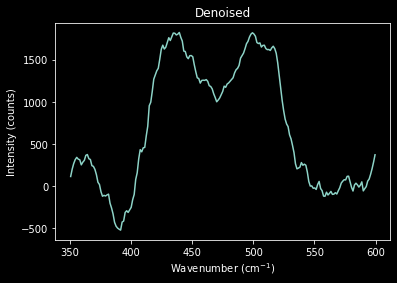

Amplitudes: [1289.68888849 1257.65009028 1827.15266965]
Centers: [427.78630167 452.48010037 503.62939907]
Sigmas: [11.21425681 17.54279747 18.23679368]


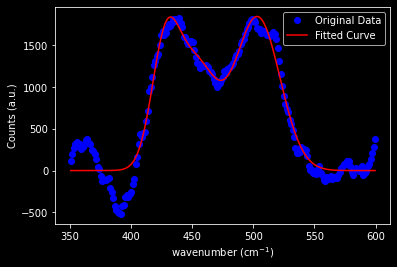

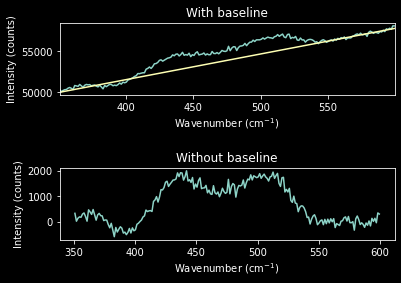

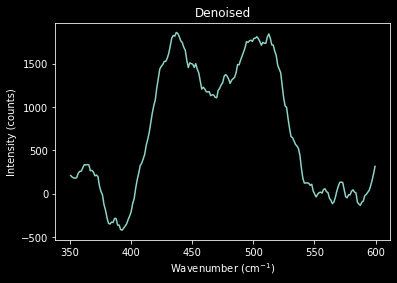

Amplitudes: [1578.79810643 1128.07098226 1554.93286928]
Centers: [433.55163067 472.78693679 510.68318208]
Sigmas: [13.60928521 22.53848169 15.99042219]


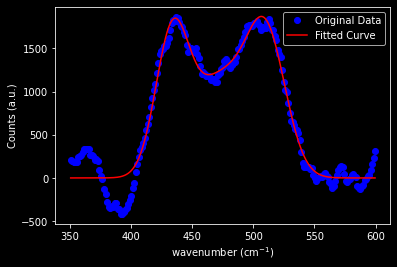

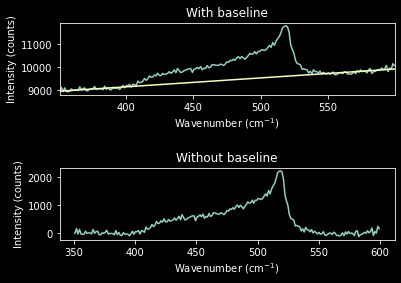

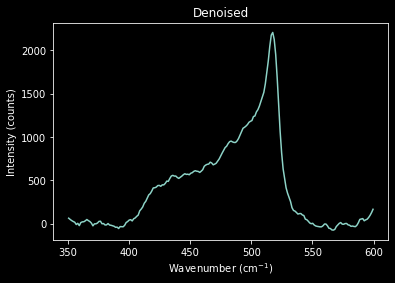

Amplitudes: [ 614.45092016 1115.18876974 1414.06615617]
Centers: [450.10985255 501.43364936 517.36843655]
Sigmas: [25.63669513 17.45552166  4.79187997]


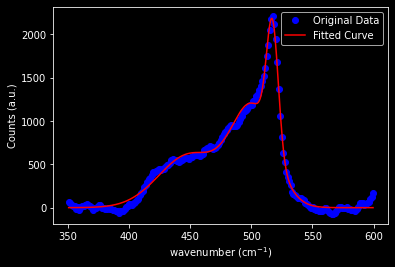

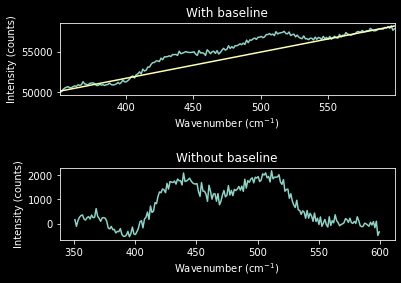

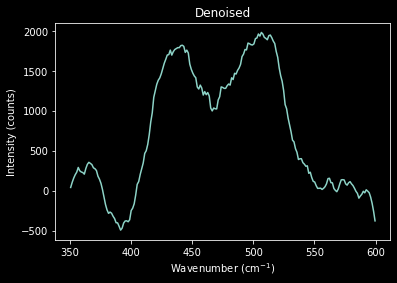

Amplitudes: [1708.05644368 1388.97445989 1001.42255518]
Centers: [435.01065863 489.0007749  512.9810572 ]
Sigmas: [14.1770466  27.09655742 12.72161742]


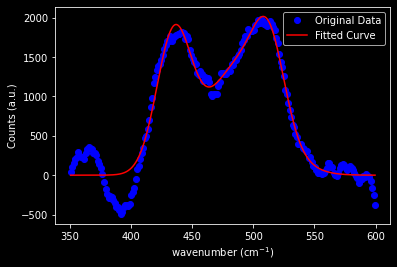

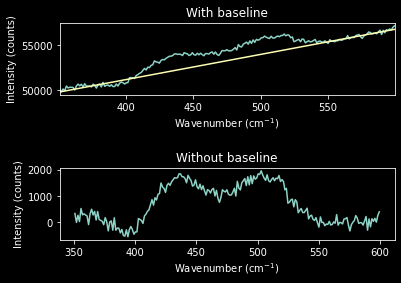

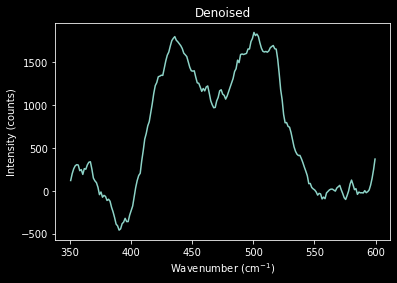

Amplitudes: [1225.7844582 1103.0248872 1820.475113 ]
Centers: [429.21230432 453.02269125 504.01932131]
Sigmas: [11.97610637 17.55544518 19.14876425]


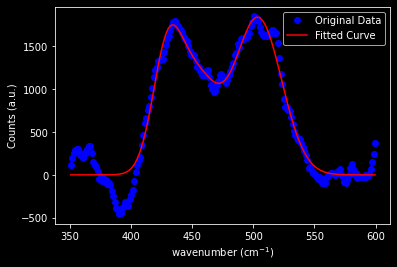

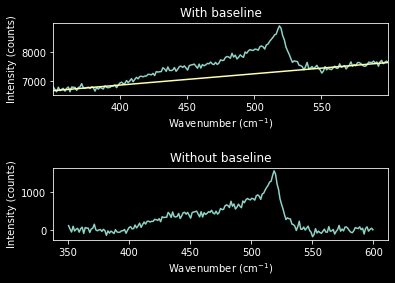

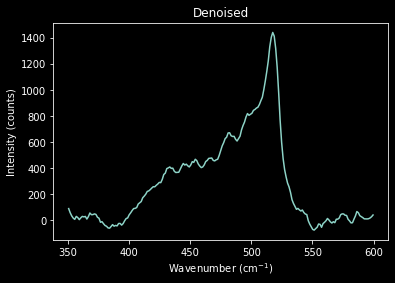

Amplitudes: [437.32232666 767.98792773 908.4228457 ]
Centers: [448.2456751  501.36744108 517.74120651]
Sigmas: [24.77781034 17.86047311  4.88539985]


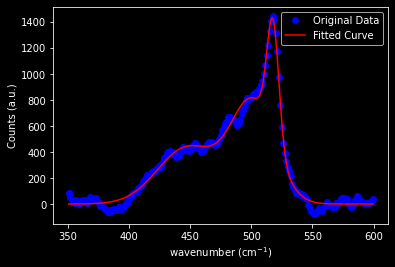

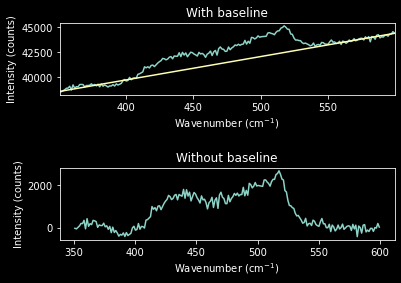

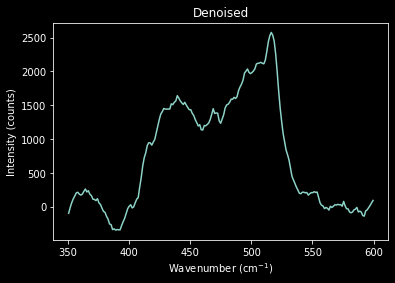

Amplitudes: [1567.91127576 1919.0417011  1220.93140441]
Centers: [437.51839228 496.47301844 516.81782997]
Sigmas: [16.96299047 22.52346588  5.73472553]


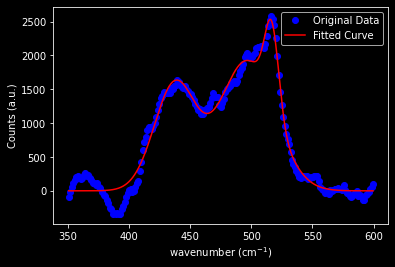

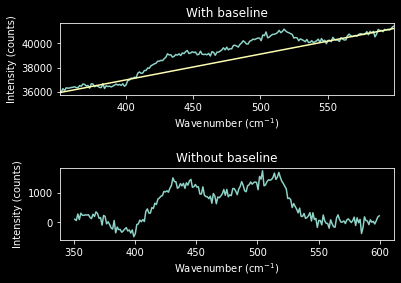

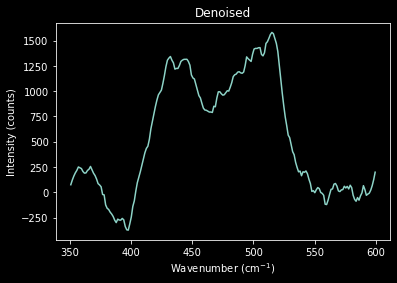

Amplitudes: [1329.70985281 1257.31311159  746.15074858]
Centers: [436.44557263 493.48451511 516.17196696]
Sigmas: [15.05237523 23.21171816  7.69151366]


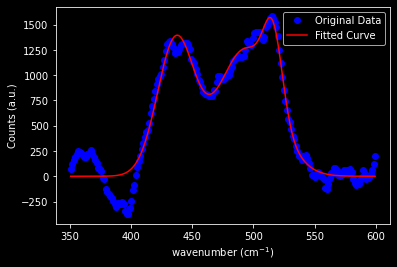

<Figure size 432x288 with 0 Axes>

In [92]:
stats = {}

for f in files:
    sp0 = RamanSpectrum(f)
    sp0.crop(lower=350, upper=600)
    sp0.polifit(a=400, b = 550, ord = 1)
    sp0.sav_gol(10,2,sp0.polylx,sp0.polyly,show=True)
    sp0.get_fitting(f2 = 0.7, f3 = 0.3 , c1 = 515, c2 = 500, c3 = 410, s1 = 10, s2 = 20, s3 = 70 ,show = True)
    stats[sp0.metadata['Acquired']] = (sp0.popt,sp0)

In [4]:
def gaussian(x, amplitude, center, sigma):
    return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))

1584.796496113912 430.14115443196147 12.001046023638715
1229.7525925693076 456.6206177596714 18.09489433850342
2026.7994526057182 504.485838104746 17.82482653186733
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



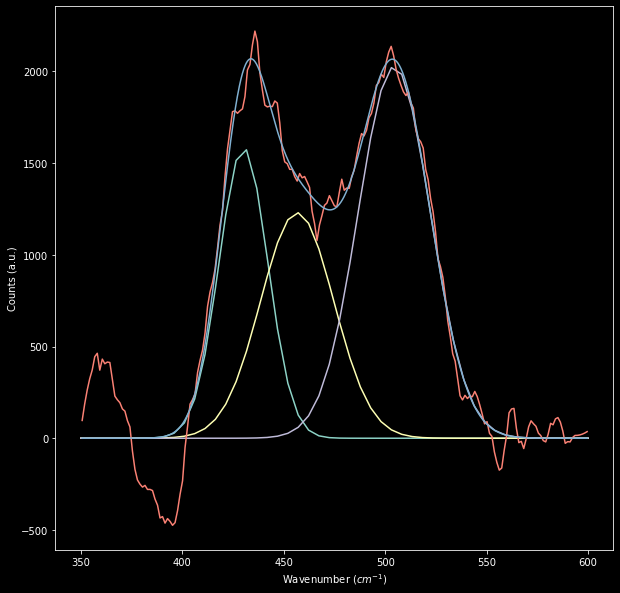

1267.2029265058768 430.15395444844097 12.604663407015614
991.7408800641088 456.2791062861261 18.58439654735402
1767.4852903426706 505.71850740773385 17.925762829190788
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



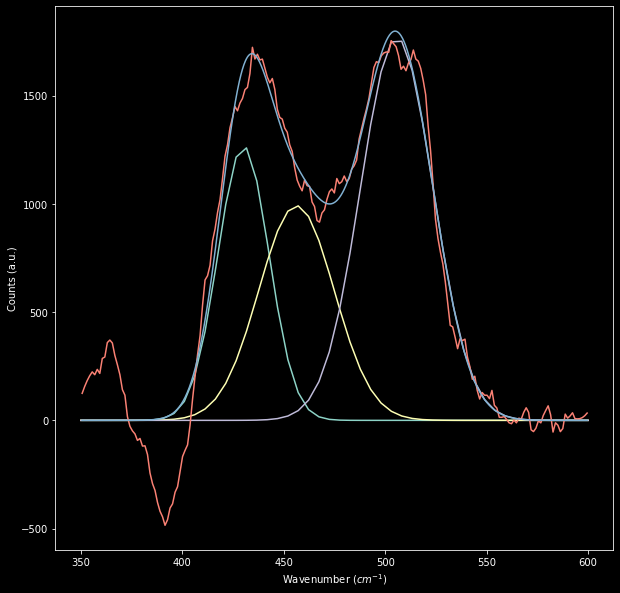

750.4065854828407 434.34408715519584 14.272392592794922
632.0006476575286 488.8156643197672 27.143976850638925
450.82038770552083 512.772043429487 14.003239521785124
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



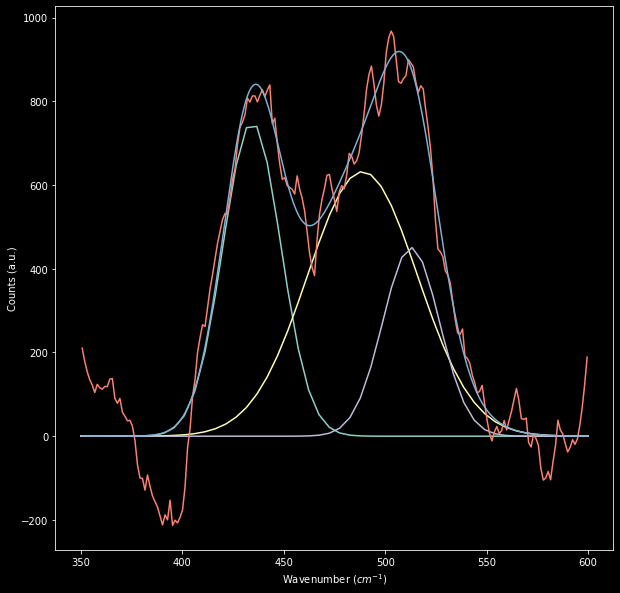

528.0639930931085 449.27573537712163 24.740585552913398
903.9401948651449 501.6240765240146 18.449152120148817
1117.435018826402 517.1145983457702 4.7136692016093455
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



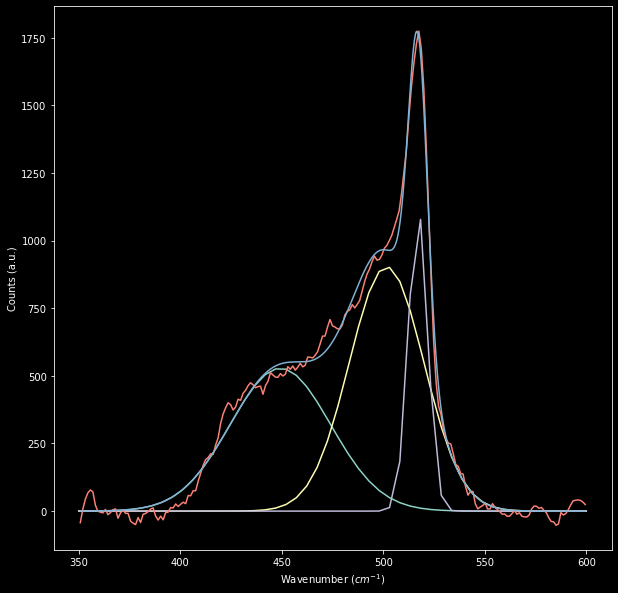

589.4025217193066 444.4214073684475 22.13159885642595
1111.614837974393 499.20864219545507 18.386174864057022
1254.1637421930611 517.1628704385851 5.134945961235242
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



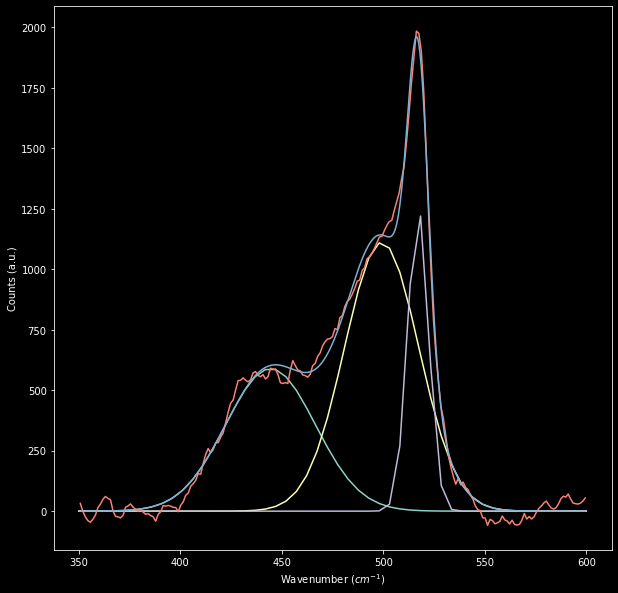

1812.9129857985931 436.4725340524592 15.780747590324426
1951.4896546882896 496.0121524255586 22.86443046819125
1420.2528105758493 517.1999134915544 5.375103815454081
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



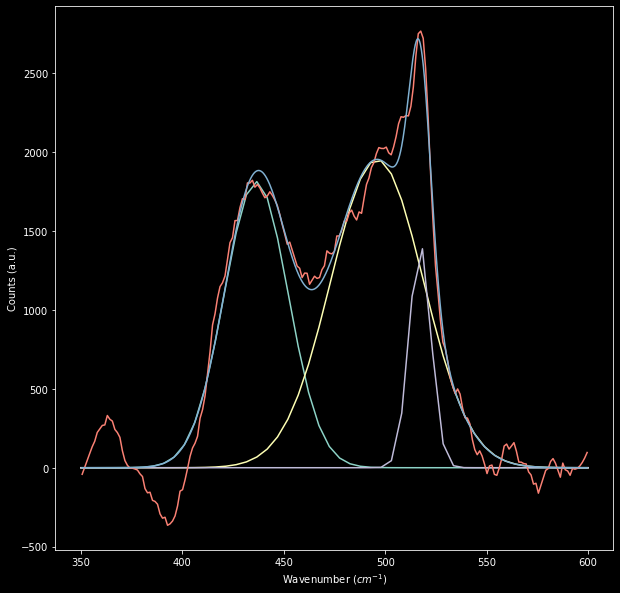

1500.6013906151704 436.03555719626667 14.967632047776025
1272.2430621889464 496.16935934836755 23.668897999524248
338.45790692307224 513.7422376277306 6.917552885675719
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



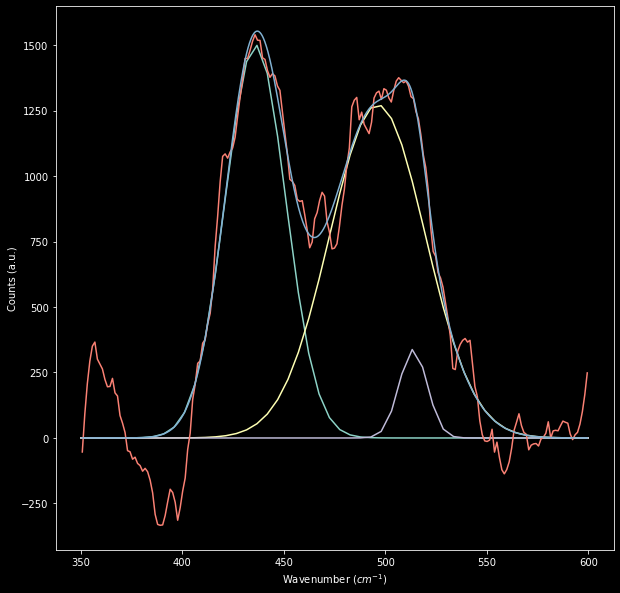

1775.0061633898636 434.5716051969393 14.219718505972107
1582.6395702645896 494.3704248758345 24.393663652037215
459.9469557652487 515.6869523929128 7.662590212551125
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



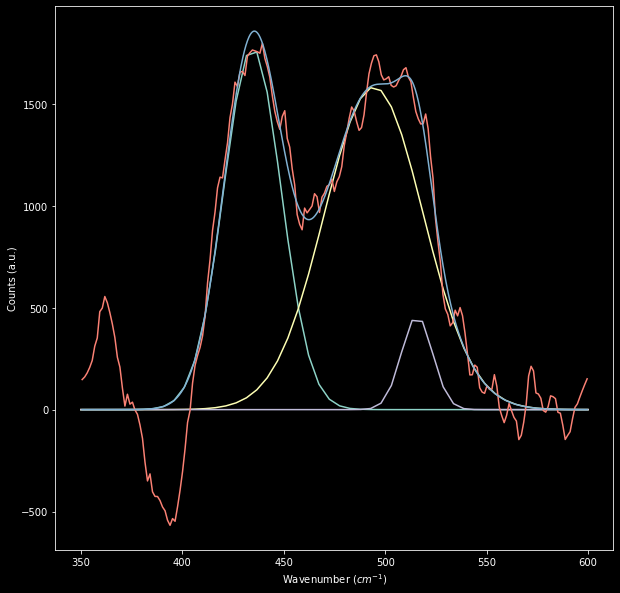

598.1964489903468 434.2268732151814 16.391459245126043
817.7445311807958 495.6554859979152 23.21081357448799
673.1839162734533 517.2996423283099 4.96839228308777
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



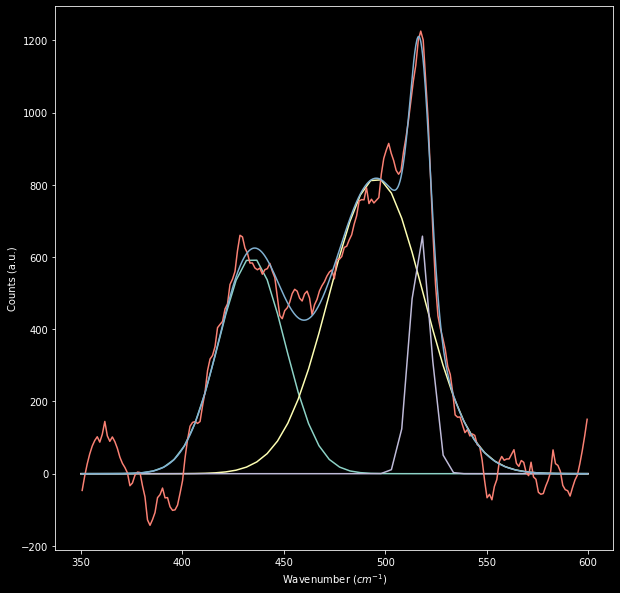

1450.8841239708793 435.5624032430397 15.076105034842143
1231.9254855101535 489.98468284439906 24.67864786198226
690.1751557522979 514.9818804023739 11.472963067821734
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



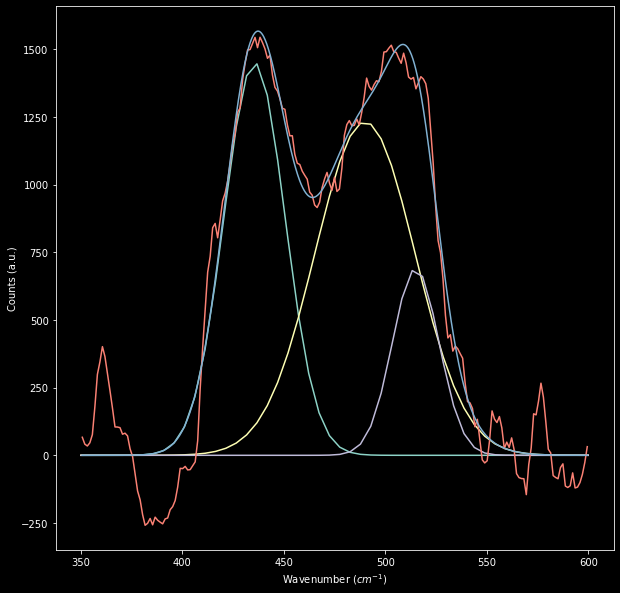

1546.9365635460053 436.5586504603154 15.806715571044263
1760.1537595387106 496.8925457257262 24.487636115246186
984.8757264125708 517.0452367621664 5.447465048021172
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



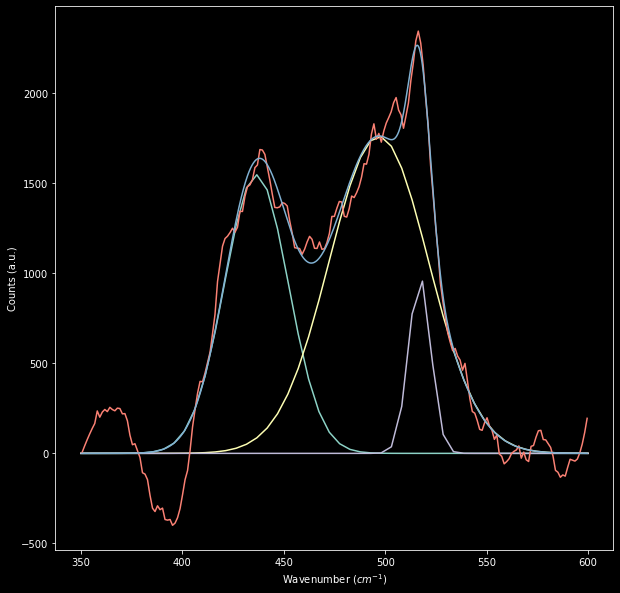

1173.9964563765366 428.6956587925524 10.322484090782368
1115.4847858025553 451.5580551844456 16.75888440968503
1774.1508939352095 504.31397619974814 19.294085750256322
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



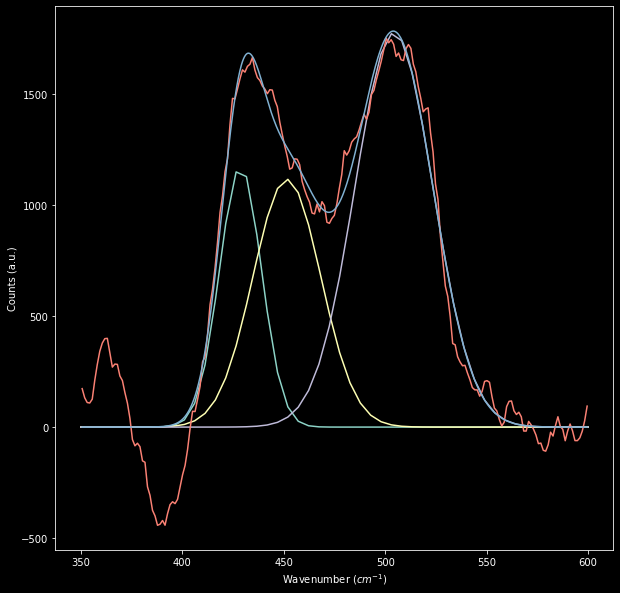

1289.6888884907833 427.78630167268165 11.214256812585079
1257.6500902778284 452.4801003671585 17.542797473938418
1827.1526696540873 503.62939906848356 18.236793681646752
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



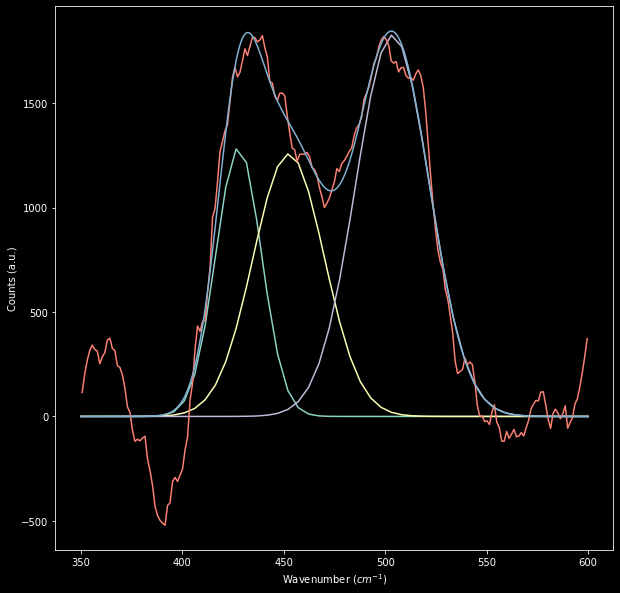

1578.7981064313976 433.551630665608 13.609285209101147
1128.07098225732 472.78693679419393 22.538481690956722
1554.9328692776942 510.6831820817466 15.990422191533266
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



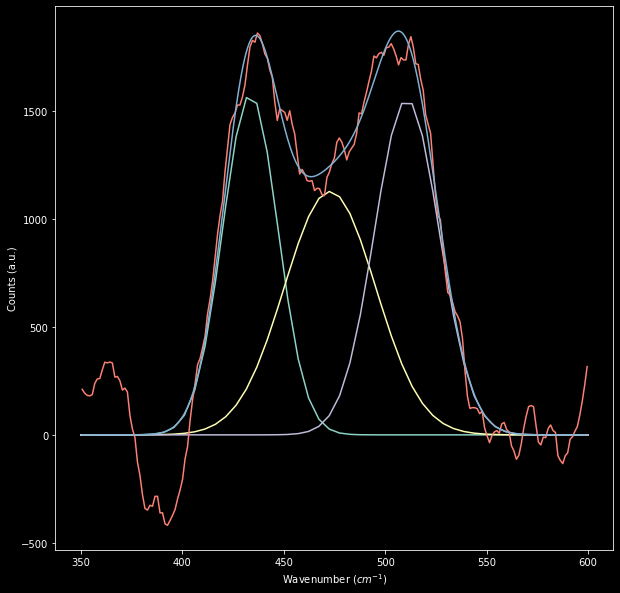

614.4509201555085 450.109852554658 25.636695131050434
1115.1887697411098 501.43364935866305 17.455521656169743
1414.0661561721724 517.368436546416 4.791879968894604
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



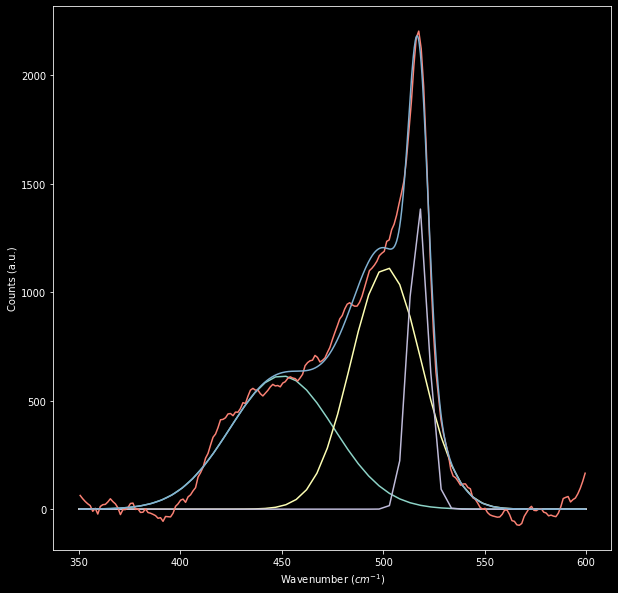

1708.0564436827335 435.01065862649637 14.177046601536277
1388.9744598862897 489.00077490150505 27.09655742197232
1001.4225551816254 512.9810572013225 12.721617415763824
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



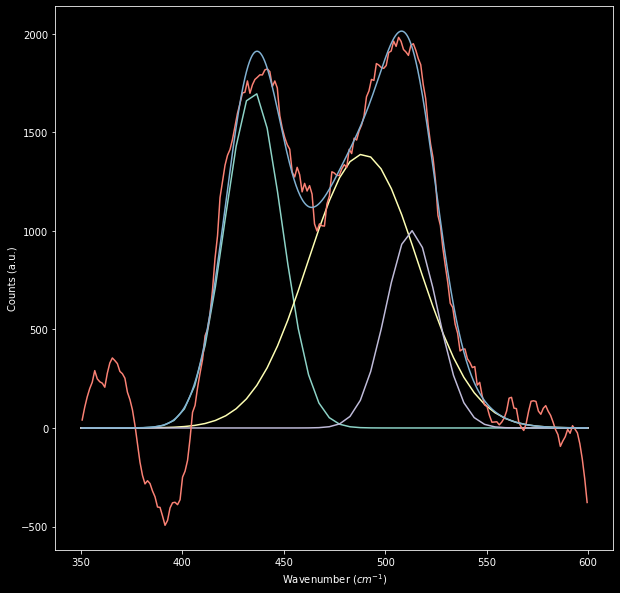

1225.7844582001167 429.21230431602646 11.976106365056179
1103.0248871964682 453.02269125270885 17.555445179843204
1820.475113002842 504.01932131264067 19.148764251748773
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



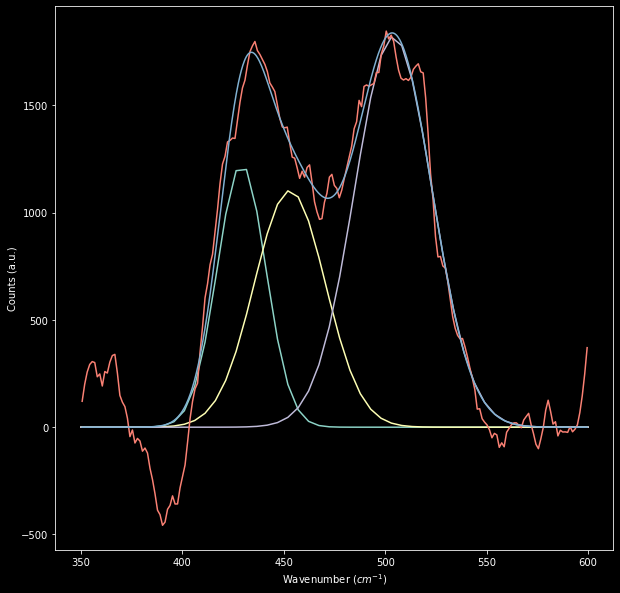

437.32232665935555 448.2456750999319 24.777810340826903
767.9879277322765 501.3674410782993 17.860473105515357
908.4228456977803 517.7412065097077 4.885399847996158
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



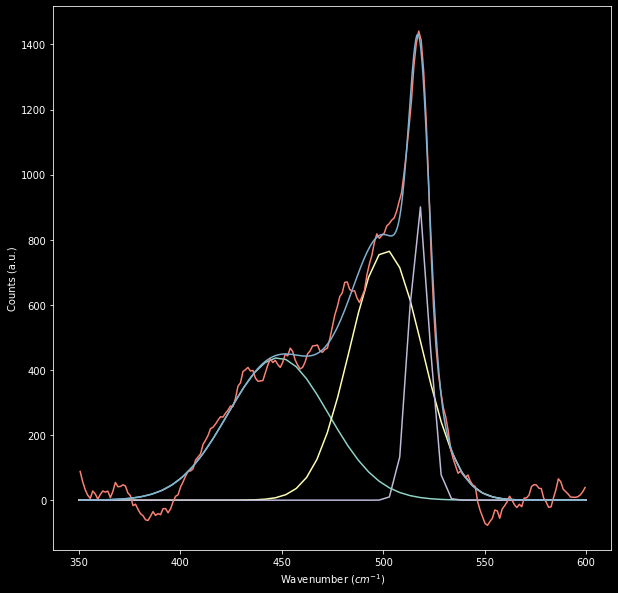

1567.9112757590499 437.5183922813083 16.962990466303868
1919.041701100952 496.47301843587826 22.523465879596692
1220.9314044086866 516.8178299702814 5.734725529154379
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



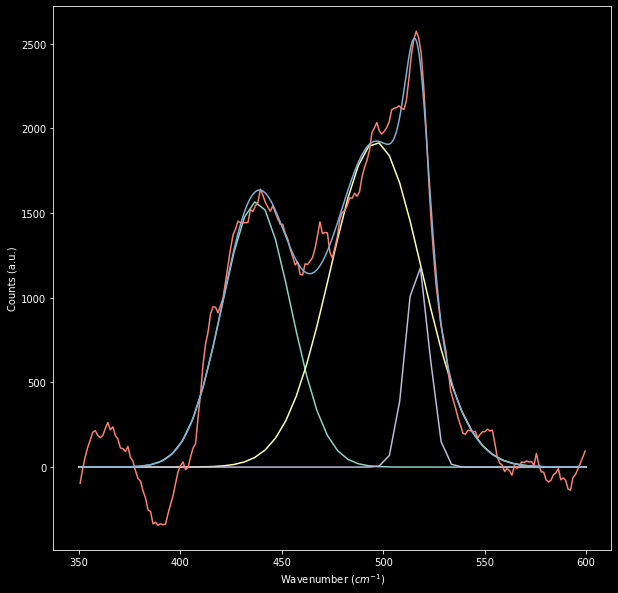

1329.7098528065235 436.4455726313146 15.052375233873255
1257.3131115938 493.4845151075342 23.211718161176766
746.1507485766261 516.1719669612921 7.691513661582142
######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 

######## 



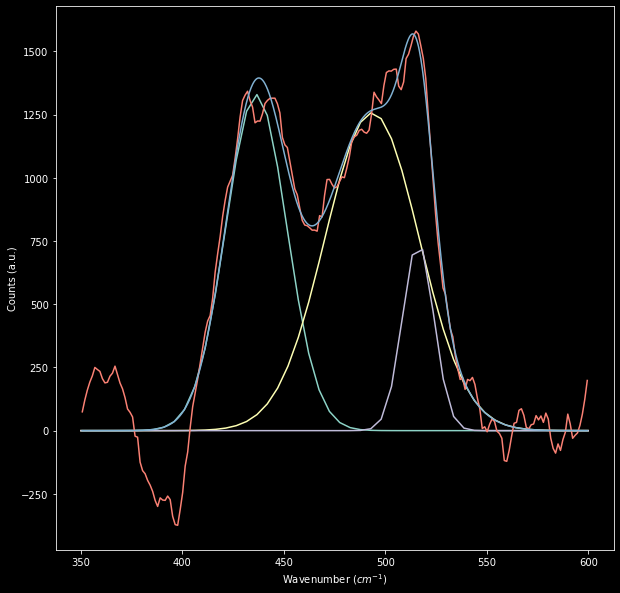

In [108]:
spectrums = list(stats.keys())
pops_data = {}

for spec in spectrums:
    ob = stats[spec][1]
    g = []
    gy = []

    x = np.linspace(350,600)

    exp_x = ob.basedx
    exp_y = ob.basedy
    fit_x = ob.x_fit
    fit_y = ob.y_fit

    for i in range(0,3):
        a,c,s = ob.popt[i*3:(i+1)*3]
        g.append([a,c,s])
        print(a,c,s)
        gy.append(gaussian(x,a,c,s))
    plt.figure(figsize=(10,10))
    plt.plot(x,gy[0])
    plt.plot(x,gy[1])
    plt.plot(x,gy[2])
    plt.plot(exp_x,exp_y)
    plt.plot(fit_x,fit_y)
    plt.xlabel('Wavenumber $(cm^{-1})$')
    plt.ylabel('Counts (a.u.)')
    for e in ob.popt:
        if e < 0:
            print('######## \n \n  pops')
            print(e, ob.popt)
            print(ob.metadata['Acquired']=='21.03.2023 10:08:20')
        print('######## \n')
    pops_data[spec] = ob.popt
    plt.savefig('frames/'+spec+'.png')
    plt.show()


In [96]:
x = []
y = []
c = 1
for name in spectrums[1:]:
    params = pops_data[name]
    for e in params:
        if e<0:
            print('Warning')
    x.append(c)
    y.append(params[])
    c += 1

plt.plot(x,y,'o')     

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2291131084.py, line 10)

In [43]:

def gaussian(self, x, amplitude, center, sigma):
    return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))


In [59]:
# Working with the popts
i = 3
measurements = list(stats.keys())
m_i = measurements[i]

r = stats[m_i]

In [61]:
ram = r[1]

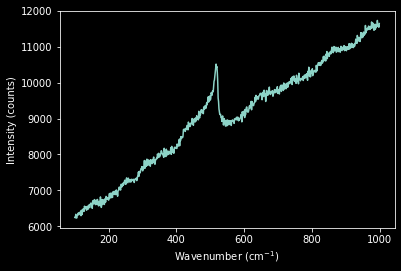

In [62]:
ram.plot()

In [30]:
r

array([1548.1155266 ,  435.49101331,   16.22579184, 1628.23186428,
        494.78935013,   26.75592337,  660.56738731,  516.29329228,
          6.68771023])

In [ ]:
def size(x_s, x_0):
    

510.54458315493866
511.60891530584524
513.5578333764325
517.0991168825497
517.1672839893126
517.2275747789001
513.4744925987908
515.7504450377455
517.3064657359814
515.3775057043373
517.0599775181663
512.3053137938463
511.7311362095382
514.165066814873
517.3328465937681
513.3404529918832
512.1651238850073
517.7155477379987
516.8081740871748
516.293292283363


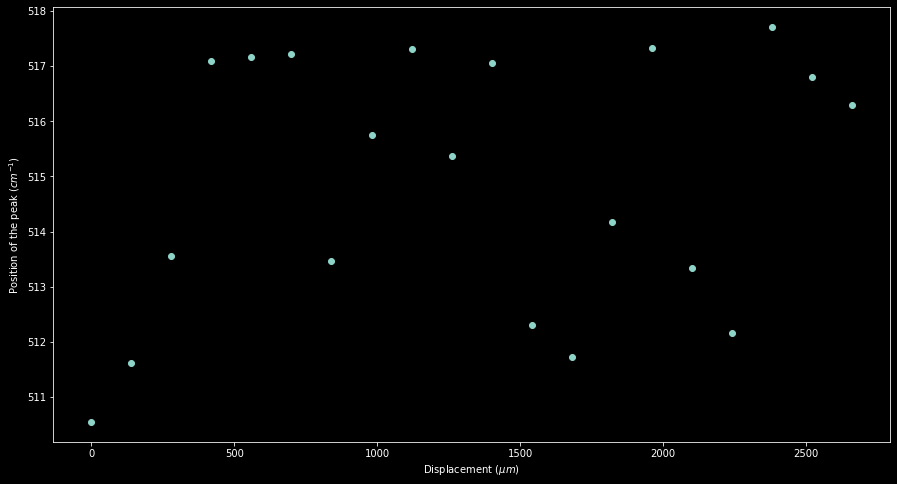

In [78]:

y = []
x = []
c = 0

f=7

for measure in measurements:
    r = stats[measure][0]
    print(r[7])
    x.append(c)
    c += 140 
    y.append(r[7])

plt.figure(figsize=(15,8))
plt.xlabel('Displacement ($\mu m$)')
plt.ylabel('Position of the peak ($cm^{-1}$)')
plt.plot(x,y,'o')

13.554072396798595
12.669445041629572
12.090033320204908
4.702713330297772
5.054024392513933
5.155495918748484
6.025267312425402
6.7707983720465394
4.822859747272944
10.31188494654797
5.193368068741855
12.399912896109159
14.725306260333673
14.47943425243524
4.735081489845033
11.576469344564519
15.968961262363447
4.774645041352284
5.563755131880787
6.687710231863241


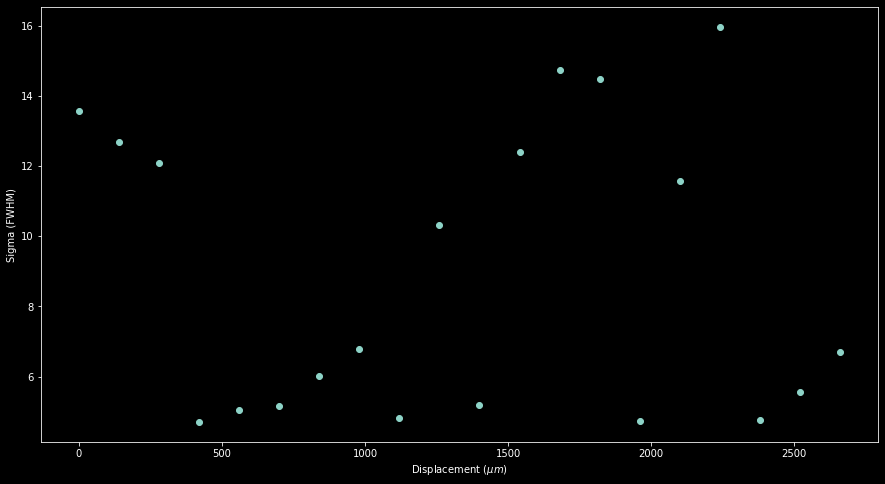

In [81]:

y = []
x = []
c = 0

f=8

for measure in measurements:
    r = stats[measure][0]
    print(r[8])
    x.append(c)
    c += 140 
    y.append(r[8])

plt.figure(figsize=(15,8))
plt.xlabel('Displacement ($\mu m$)')
plt.ylabel('Sigma (FWHM)')
plt.plot(x,y,'o')

Amplitudes: [ 547.74475468  927.69929139 1113.27461134]
Centers: [448.55565924 501.58422005 517.09911688]
Sigmas: [24.77897379 18.89281035  4.70271333]


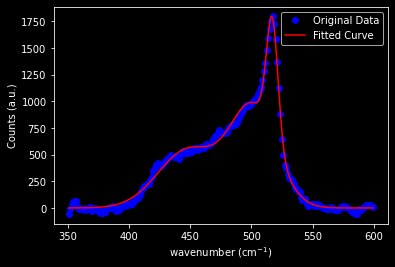

<Figure size 432x288 with 0 Axes>

In [36]:
sp0.get_fitting(f2 = 0.7, f3 = 0.3 , c1 = 515, c2 = 500, c3 = 410, s1 = 10, s2 = 20, s3 = 70 ,show = True)

In [39]:
pop = sp0.popt

In [44]:
pop

array([ 547.74475468,  448.55565924,   24.77897379,  927.69929139,
        501.58422005,   18.89281035, 1113.27461134,  517.09911688,
          4.70271333])

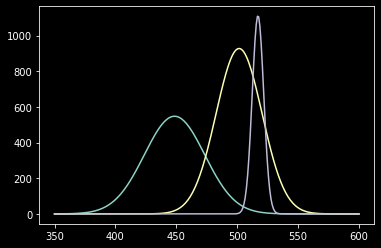

In [64]:
for e in


    s1 = pop[0:3]
    s2 = pop[3:6]
    s3 = pop[6:9]

    x = np.linspace(350,600, 250)

    def gaussian(x, amplitude, center, sigma):
        return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))
    g = []

    for s in [s1,s2,s3]:
        g.append(gaussian(x,s[0],s[1],s[2]))

    plt.plot(x,g[0])
    plt.plot(x,g[1])
    plt.plot(x,g[2])

In [6]:
# We use gx and gy to fit this to a voigt profile
# Importing the wofz function from scipy.special

from scipy.special import wofz

def voigt(x, amp, cen, sig, gam):
    return amp * np.real(wofz(((x-cen) + 1j*gam)/sig/np.sqrt(2))) / sig / np.sqrt(2*np.pi)

# We need to define the initial guess for the parameters
center= 518
sigma = 30
gamma = -60
amplitude = 2000

# Now we can fit the data minimizing the difference between the actual data and the model using the curve_fit function from scipy.optimize

from scipy.optimize import curve_fit

# Using the initial parameters we defined above, we can fit the data

def plot_fit(xdata, ydata):
    popt, pcov = curve_fit(voigt, xdata, ydata, p0=[amplitude, center, sigma, gamma])

    # Plot the data and the fit
    plt.plot(xdata, ydata, 'b-', label='data')
    plt.plot(xdata, voigt(xdata, *popt), 'r-', label='fit')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    # Print the optimized parameters
    print('Optimized Amplitude = ', popt[0])
    print('Optimized Center = ', popt[1])
    print('Optimized Sigma = ', popt[2])
    print('Optimized Gamma = ', popt[3])
    plt.show()

plot_fit(nx, ny)

NameError: name 'nx' is not defined

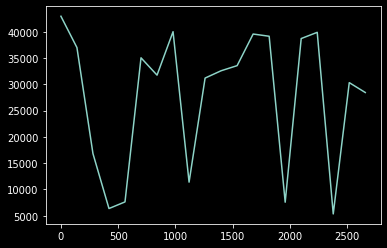

In [107]:
####
""" 
Creating the base poly for the stats
"""
xa = []
xb = []
xs = []
ii = 0

for m in measurements:
    r = stats[m][1]
    xa.append(r.fitted[0])
    xb.append(r.fitted[1])
    xs.append(ii)
    ii += 140

plt.plot(xs, xb)
    

In [102]:
xb

[42963.83305426907,
 37000.84172036765,
 16823.27443744329,
 6370.095301346394,
 7628.678544111808,
 35052.06235156968,
 31757.3269450975,
 40024.566340384335,
 11391.833463526495,
 31197.43426286679,
 32589.450063681194,
 33562.920647537205,
 39577.798583711374,
 39156.09397883272,
 7574.125670078558,
 38719.0220372979,
 39901.36446245208,
 5343.465278158508,
 30328.731092744667,
 28448.02737272009]

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz
import ipywidgets as widgets
from IPython.display import display

def voigt(x, amp, cen, sig, gam):
    return amp * np.real(wofz(((x - cen) + 1j * gam) / sig / np.sqrt(2))) / sig / np.sqrt(2 * np.pi)

# Define the x-axis range
x = np.linspace(-100, 100, 10000)

# Create initial values for the parameters
initial_amp = 1.0
initial_cen = 0.0
initial_sig = 1.0
initial_gam = 1.0

# Create sliders for each parameter
amp_slider = widgets.FloatSlider(value=initial_amp, min=0.1, max=10.0, step=0.1, description='Amplitude:')
cen_slider = widgets.FloatSlider(value=initial_cen, min=-5.0, max=5.0, step=0.1, description='Center:')
sig_slider = widgets.FloatSlider(value=initial_sig, min=1.0, max=50.0, step=1.0, description='Sigma:')
gam_slider = widgets.FloatSlider(value=initial_gam, min=1.0, max=50.0, step=1.0, description='Gamma:')

# Define the update function
def update_plot(amp, cen, sig, gam):
    y = voigt(x, amp, cen, sig, gam)
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Voigt Curve')
    plt.ylim(0, np.max(y) + 0.5)
    plt.show()

# Create the interactive plot
interactive_plot = widgets.interactive(update_plot, amp=amp_slider, cen=cen_slider, sig=sig_slider, gam=gam_slider)

# Display the interactive plot
display(interactive_plot)


interactive(children=(FloatSlider(value=1.0, description='Amplitude:', max=10.0, min=0.1), FloatSlider(value=0…

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz
import ipywidgets as widgets
from IPython.display import display

def voigt(x, amp, cen, sig, gam):
    return amp * np.real(wofz(((x - cen) + 1j * gam) / sig / np.sqrt(2))) / sig / np.sqrt(2 * np.pi)

# Define the x-axis range
x = np.linspace(-100, 100, 10000)

# Create initial values for the parameters of the first curve
initial_amp_1 = 1.0
initial_cen_1 = 0.0
initial_sig_1 = 1.0
initial_gam_1 = 1.0

# Create initial values for the parameters of the second curve
initial_amp_2 = 0.5
initial_cen_2 = -1.0
initial_sig_2 = 2.0
initial_gam_2 = 0.5

# Create sliders for the parameters of the first curve
amp_slider_1 = widgets.FloatSlider(value=initial_amp_1, min=0.1, max=10.0, step=0.1, description='Amplitude 1:')
cen_slider_1 = widgets.FloatSlider(value=initial_cen_1, min=-5.0, max=5.0, step=0.1, description='Center 1:')
sig_slider_1 = widgets.FloatSlider(value=initial_sig_1, min=1.0, max=50.0, step=1.0, description='Sigma 1:')
gam_slider_1 = widgets.FloatSlider(value=initial_gam_1, min=1.0, max=50.0, step=1.0, description='Gamma 1:')

# Create sliders for the parameters of the second curve
amp_slider_2 = widgets.FloatSlider(value=initial_amp_2, min=0.1, max=10.0, step=0.1, description='Amplitude 2:')
cen_slider_2 = widgets.FloatSlider(value=initial_cen_2, min=-5.0, max=5.0, step=0.1, description='Center 2:')
sig_slider_2 = widgets.FloatSlider(value=initial_sig_2, min=1.0, max=50.0, step=1.0, description='Sigma 2:')
gam_slider_2 = widgets.FloatSlider(value=initial_gam_2, min=1.0, max=50.0, step=1.0, description='Gamma 2:')

# Define the update function
def update_plot(amp_1, cen_1, sig_1, gam_1, amp_2, cen_2, sig_2, gam_2):
    y1 = voigt(x, amp_1, cen_1, sig_1, gam_1)
    y2 = voigt(x, amp_2, cen_2, sig_2, gam_2)
    plt.figure(figsize=(20, 10))
    plt.plot(x, y1, label='Curve 1')
    plt.plot(x, y2, label='Curve 2')
    plt.plot(x, y1+y2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Voigt Curves')
    plt.ylim(0, max(np.max(y1), np.max(y2)) + 0.5)
    plt.legend()
    plt.show

interactive_plot = widgets.interactive(update_plot, amp_1=amp_slider_1, cen_1=cen_slider_1, sig_1=sig_slider_1, gam_1=gam_slider_1, amp_2=amp_slider_2, cen_2=cen_slider_2, sig_2=sig_slider_2, gam_2=gam_slider_2)
# Display the interactive plot
display(interactive_plot)



interactive(children=(FloatSlider(value=1.0, description='Amplitude 1:', max=10.0, min=0.1), FloatSlider(value…

In [37]:
import cmath

def solve_quadratic(a, b, c):
    # Calculate the discriminant
    discriminant = (b ** 2) - (4 * a * c)

    # Check if the discriminant is positive, negative, or zero
    if discriminant > 0:
        # Two real and distinct roots
        root1 = (-b + cmath.sqrt(discriminant)) / (2 * a)
        root2 = (-b - cmath.sqrt(discriminant)) / (2 * a)
        return root1, root2
    elif discriminant == 0:
        # One real root (repeated)
        root = -b / (2 * a)
        return root, root
    else:
        # Two complex roots
        real_part = -b / (2 * a)
        imaginary_part = cmath.sqrt(-discriminant) / (2 * a)
        root1 = complex(real_part, imaginary_part)
        root2 = complex(real_part, -imaginary_part)
        return root1, root2

# Example usage
a = (0.53)*5
b = 5*(0.543)
c = (-120.8)*(0.543**2)
root1, root2 = solve_quadratic(a, b, c)

print("Root 1:", root1)
print("Root 2:", root2)


Root 1: (3.189502779780142+0j)
Root 2: (-4.214031081666934+0j)


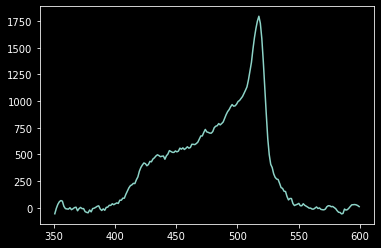

In [64]:
plt.plot(ram.basedx,ram.basedy)

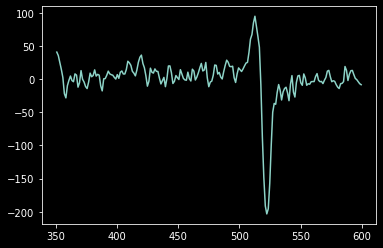

In [65]:
import numpy as np

# Define the function
x = ram.basedx
y = ram.basedy

# Calculate the derivative
dy_dx = np.gradient(y, x)

plt.plot(x,dy_dx)

In [ ]:
# Define the function as the sum of three Gaussian curves
def gaussian(x, amplitude, center, sigma):
    return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))

def multi_peak_fit(x, *params):
    num_peaks = len(params) // 3
    y_fit = np.zeros_like(x)

    for i in range(num_peaks):
        amplitude, center, sigma = params[i*3 : (i+1)*3]
        y_fit += self.gaussian(x, amplitude, center, sigma)
    return y_fit

def get_fitting(self, f2 = 0.5, f3 = 0.3 , c1 = 520, c2 = 500, c3 = 480, s1 = 10, s2 = 20, s3 = 40 ,show = False):
    x = np.array(self.basedx)
    y = np.array(self.basedy)

    yspec = max(y)
    yspec2 = yspec*f2
    yspec3 = yspec*f3

    # Perform the multi-peak fitting
    # initial_guess = [yspec3, 450, 100, yspec2, 510, 10, yspec, 520, 10]
    initial_guess = [yspec3, c3, s3, yspec2, c2, s2, yspec, c1, s1]   # Initial guess for parameters: [amplitude1, center1, sigma1, amplitude2, center2, sigma2, amplitude3, center3, sigma3]
    
    if not os.path.exists(self.sample+'/fit'):
            os.makedirs(self.sample+'/fit')

    popt, pcov = curve_fit(self.multi_peak_fit, x, y, p0=initial_guess)